In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry

# Loading the data

In [2]:
#adapt folder path
data_folder = './Data/'
path_ba = data_folder + 'BeerAdvocate/'
#corresponds to a smaller version of reviews.txt
path_ba_reviews = data_folder + "reviews_small.txt"

In [3]:
#get csvs
ba_beers = pd.read_csv(path_ba + "beers.csv")
ba_users = pd.read_csv(path_ba + "users.csv")
ba_brew = pd.read_csv(path_ba + "breweries.csv")
ba_brew.set_index(ba_brew['id'], inplace = True)
ba_brew.pop('id')
ba_brew.sort_index(inplace=True)

In [4]:
reviews = pd.read_pickle(data_folder + "small_review_ba")

# Data filtering and preparation

## brewerie list

In [5]:
#removing html tags
ba_brew['location'] = ba_brew['location'].apply(lambda x : x.split('<', 1)[0])
#separating country from states (for USA)
ba_brew['country'] = ba_brew['location'].apply(lambda x : x.split(',', 1)[0])

In [9]:
#find matching country iso codes
def find_iso(x):
    try:
        country = pycountry.countries.search_fuzzy(x)
        return country[0].alpha_3
    except:
        return None
country_list = ba_brew['country'].unique()
country_iso = {x: find_iso(x) for x in country_list} #look up table
ba_brew['country_code'] = ba_brew['country'].apply(lambda x: country_iso[x])

In [130]:
#special detailed dataframe for usa
brew_usa = ba_brew[ba_brew['country'] == 'United States']
states = brew_usa['location'].apply(lambda x : str(x.split(',', 1)[1])[1:] if ',' in x else None)
brew_usa = brew_usa.assign(states = states)

In [131]:
#beer count per country
beer_country = ba_brew.groupby(ba_brew["country_code"]).sum().sort_values(by = 'nbr_beers', ascending = False)
beer_states = brew_usa.groupby(brew_usa["states"]).sum().sort_values(by = 'nbr_beers', ascending = False)

# Data Visualisation

## stats about beers

### alcohol content (abv)

In [5]:
print(f"number of Nan in abv: {ba_beers['abv'].isna().sum()}")
print(f"number of beers on site: {len(ba_beers)}")

number of Nan in abv: 36024
number of beers on site: 280823


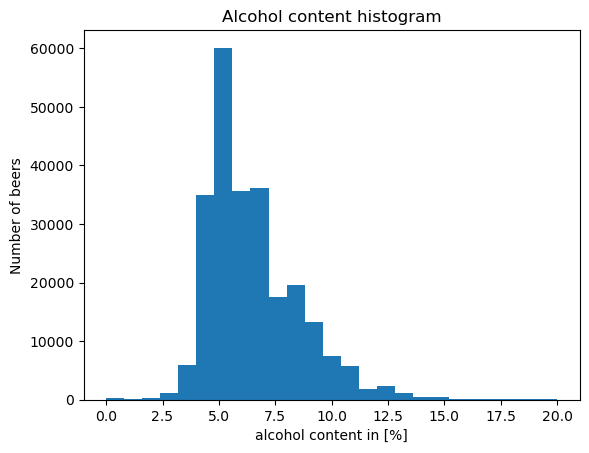

In [6]:
plt.hist(ba_beers['abv'].dropna(), bins=25, range=(0, 20))
plt.xlabel('alcohol content in [%]')
plt.ylabel('Number of beers')
plt.title('Alcohol content histogram');

### beer types

In [7]:
#number of types of beer
style_counts = ba_beers["style"].value_counts()
print(len(style_counts))

104


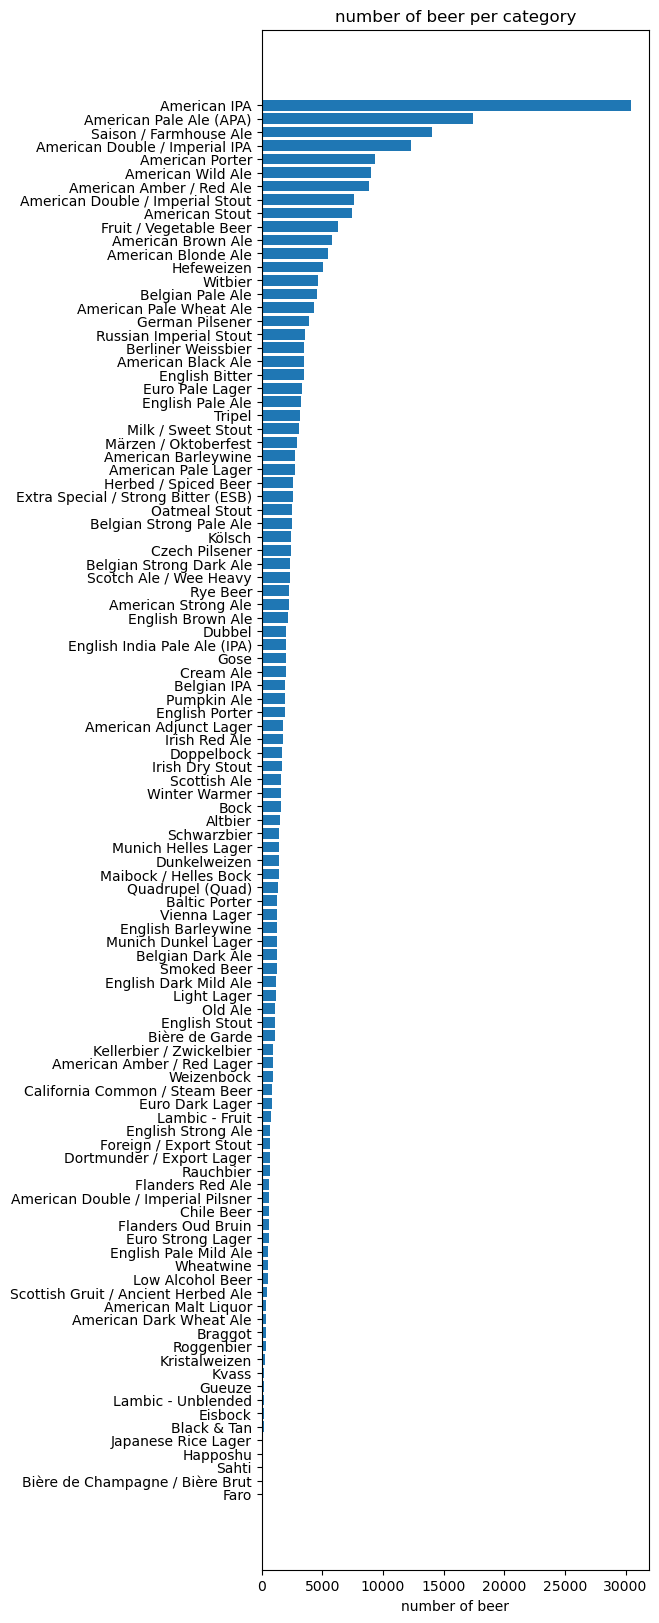

In [8]:
fig, ax = plt.subplots(figsize = (5, 20))
ax.barh(style_counts.index, style_counts, align='center')
#ax.set_yticks(style_counts.index(), labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('number of beer')
ax.set_title('number of beer per category')
plt.show()

In [9]:
american_style = [x for x in style_counts.index if "American" in x]
german_style = [x for x in style_counts.index if ("German" in x or "Munich" in x)]

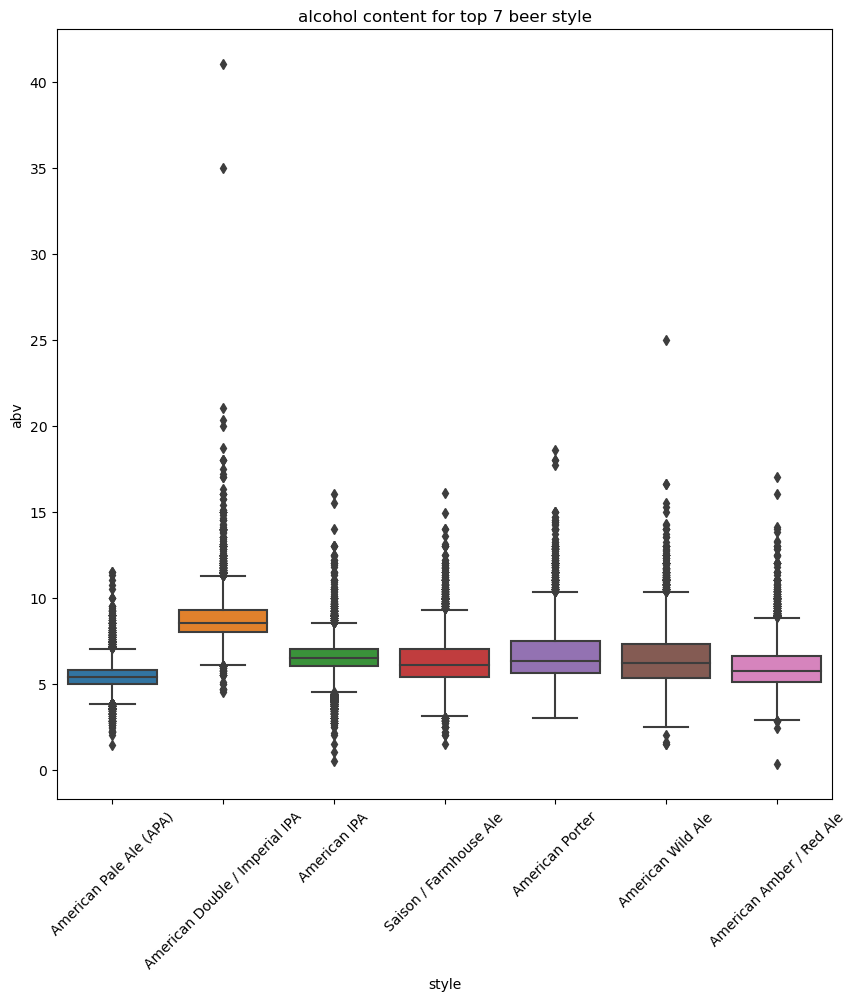

In [10]:
#alcohol content amongst top 10 most popular style
result = ba_beers.groupby(ba_beers["style"]).filter(lambda x: len(x) > 8000)
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x='style', y='abv', data=result, ax=ax)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.title("alcohol content for top 7 beer style")
plt.show()

## Reviews as a time serie

# Geographical representation

In [32]:
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
import imageio
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import mapclassify as mc
import numpy as np


In [107]:
world = gpd.read_file(data_folder + "maps/world-administrative-boundaries.shp", encoding = 'utf-8')
world = world.merge(beer_country, how = "left", left_on="iso3", right_index = True, )
world = world.sort_values(by = "nbr_beers", ascending = False)
world['log_beers'] = world['nbr_beers'].apply(lambda x: np.log10(x) if x >= 1 else 0)

C:\Users\matth\anaconda3\envs\ADA\lib\site-packages\geoplot\geoplot.py:982: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


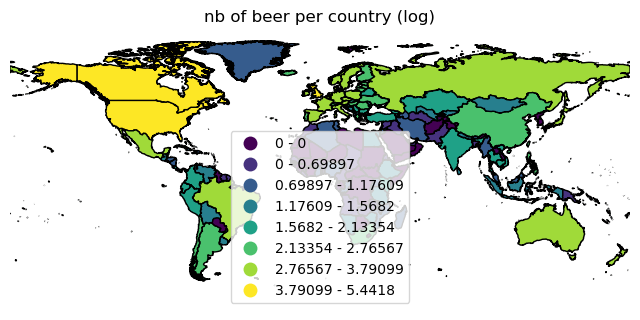

In [109]:
#number of beers per country (log)
scheme = mc.FisherJenks(world['log_beers'], k=8)
gplt.choropleth(world, hue="log_beers", legend=True, scheme=scheme)
plt.title("nb of beer per country (log10)")
plt.show()

In [123]:
beer_states.index.values

array([' California', ' Pennsylvania', ' Colorado', ' Illinois',
       ' New York', ' Oregon', ' Florida', ' Washington',
       ' Massachusetts', ' Michigan', ' North Carolina', ' Virginia',
       ' Ohio', ' Arizona', ' Indiana', ' Minnesota', ' Wisconsin',
       ' Texas', ' Maryland', ' Missouri', ' New Jersey', ' Connecticut',
       ' Delaware', ' Vermont', ' Iowa', ' New Hampshire', ' Georgia',
       ' Maine', ' South Carolina', ' Tennessee', ' New Mexico',
       ' Kentucky', ' Idaho', ' Kansas', ' Montana', ' Alaska',
       ' Nebraska', ' Nevada', ' Utah', ' Louisiana', ' Alabama',
       ' Wyoming', ' Rhode Island', ' Hawaii', ' South Dakota',
       ' Oklahoma', ' Arkansas', ' West Virginia', ' North Dakota',
       ' Mississippi', ' United States'], dtype=object)

C:\Users\matth\anaconda3\envs\ADA\lib\site-packages\geoplot\geoplot.py:56: UserWarning: The data being passed to "hue" includes null values. You probably want to remove these before plotting this data with geoplot.
  warnings.warn(


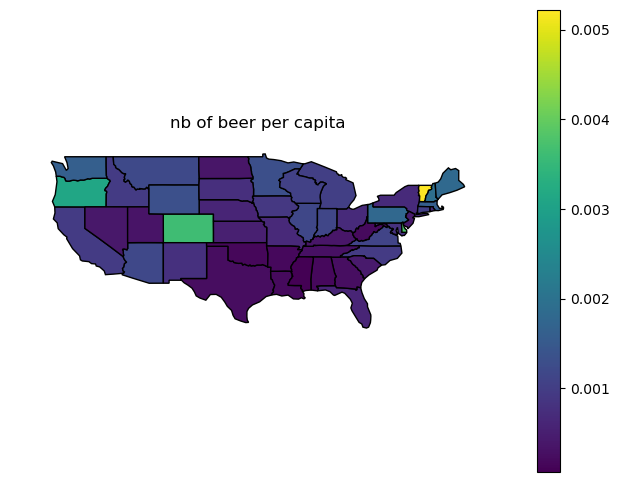

In [141]:
contiguous_usa = gpd.read_file(gplt.datasets.get_path("contiguous_usa"))
contiguous_usa = contiguous_usa.merge(beer_states, how = "left", left_on="state", right_index = True)
contiguous_usa = contiguous_usa.sort_values(by = "nbr_beers", ascending = False)
contiguous_usa["beer_per_capita"] = contiguous_usa.apply(lambda x: 0 if x["nbr_beers"] == np.nan else x["nbr_beers"]/x["population"], axis = 1)
gplt.choropleth(contiguous_usa, hue="beer_per_capita", legend=True)
plt.title("nb of beer per capita")
plt.show()